<a href="https://colab.research.google.com/github/priyasiddharth/mbedtls-ownsem/blob/main/mbedtls_ownsem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load data from github repo. Each file contains data for one benchmark. Therefore dump all data in one dictionary.

In [5]:
import requests
import json

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pdb
def load_dict_with_tuple_keys(data):
  original_dict = {tuple(eval(key)): value for key, value in data.items()}
  return original_dict

urls = {
    'many_buffers': 'https://raw.githubusercontent.com/priyasiddharth/mbedtls-ownsem/main/result_many_buffers.json',
    'flight_append': 'https://raw.githubusercontent.com/priyasiddharth/mbedtls-ownsem/main/results_flight_append.json',
    'write_handshakes_main': 'https://raw.githubusercontent.com/priyasiddharth/mbedtls-ownsem/main/results_write_handshake_main.json',
    'write_handshakes_shad': 'https://raw.githubusercontent.com/priyasiddharth/mbedtls-ownsem/main/results_write_handshake_shad.json',
    'write_records': 'https://raw.githubusercontent.com/priyasiddharth/mbedtls-ownsem/main/results_write_records.json',
}

data = {}

for key, url in urls.items():
  response = requests.get(url)
  data[key] = load_dict_with_tuple_keys(response.json())


merged_data = []
keys = []
for key, value in data.items():
  merged_data.append(value)
  keys.append(key)

The following are helper functions to draw scatter plots of Baseline vs Ownsem.

In [6]:
def sorting_key(item):
    knobname, knobval, job, times = item[0]  # Extract the key from the item
    return job

def extract_data_pair(data, subkey, parameter):
    filtered = {job: v for (knobname, knobval, job, times), v in data.items() if knobval == subkey}
    x = 0
    y = 0
    for key in filtered.keys():
      try:
        if 'ownsem' in key:
          x = filtered[key][parameter]
        else:
          y = filtered[key][parameter]
      except KeyError:
        pdb.set_trace()
    return (x, y)

def extract_datalist(data, parameter):
    knob_range = {key[1] for key in data.keys()}
    data_pairs = [(extract_data_pair(data, knob, parameter)) for knob in knob_range]
    x = [item[0] for item in data_pairs]  # Extract first element of each tuple
    y = [item[1] for item in data_pairs]  # Extract second element of each tuple
    return (x, y)  # Return tuple

def scatter_plot(x, y, job_name):
    #df = pd.DataFrame({'ownsem': x, 'baseline': y})
    # Plot scatterplot with a unique marker style for each job
    marker_styles = ['o', '^', 's', 'd', 'x']  # You can extend this list for more job names
    plt.scatter(x, y, label=job_name, marker=marker_styles.pop(0))

def plot_lines(x, y):
    # Plot y=x line
    plt.plot(x, y, label='y = x', color='#FFB6C1') #pink

    # Plot y=3x line
    plt.plot(x, [3 * val for val in x], label='y = 3x', color='#98FB98') #green

def doPlot(data, parameter, job_names):
  max_x_value = 0
  max_y_value = 0
  # Iterate over job names and plot each file separately
  for job_name, json_data in zip(job_names, data):
    x, y = extract_datalist(json_data, parameter)
    scatter_plot(x, y, job_name)
    # Update maximum x and y values
    max_x_value = max(max_x_value, max(x))
    max_y_value = max(max_y_value, max(y))

  max_marker_size = plt.rcParams['lines.markersize']
  #Get the maximum value from both x and y and adjust plot
  max_value = max(max_x_value, max_y_value) + max_marker_size
  plt.xlim(0, max_value)
  plt.ylim(0, max_value)
  # Plot y=x and y=3x lines
  x_line = np.linspace(0, max_value, 100)
  plot_lines(x_line, x_line)
  # Add grid
  plt.grid(True)
  # Add labels
  plt.xlabel('Ownsem')
  plt.ylabel('Baseline')

  # Show legend
  plt.legend()
  #plt.savefig(out_filename, format='pdf')
  #print(f'Wrote file {out_filename}')
  plt.show()

We want to evaluate time spent in SMT solver for Baseline vs Ownsem (in seconds).

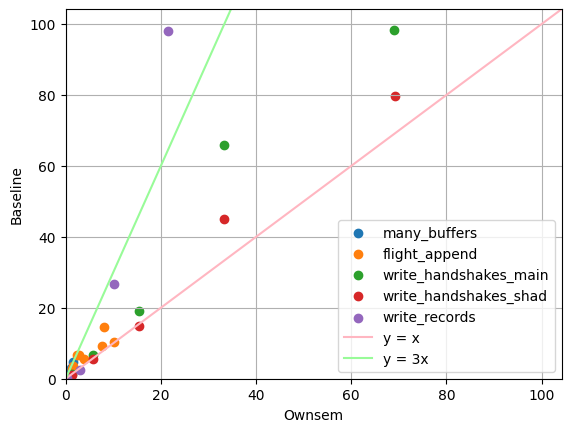

In [7]:
doPlot(merged_data, 'BMC.solve',keys)